# EDA

#### Importamos librerias 

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#### Cargamos el archivo .csv

In [3]:
# Importamos el dataset
cleanmovies = pd.read_csv('../dataset/cleanmovies.csv', sep=';', encoding='utf-8')

# Crear un nuevo DataFrame eliminando las filas con budget igual a 0
cleanmovies = cleanmovies[cleanmovies['budget'] != 0]

### Generamos una nube de palabras

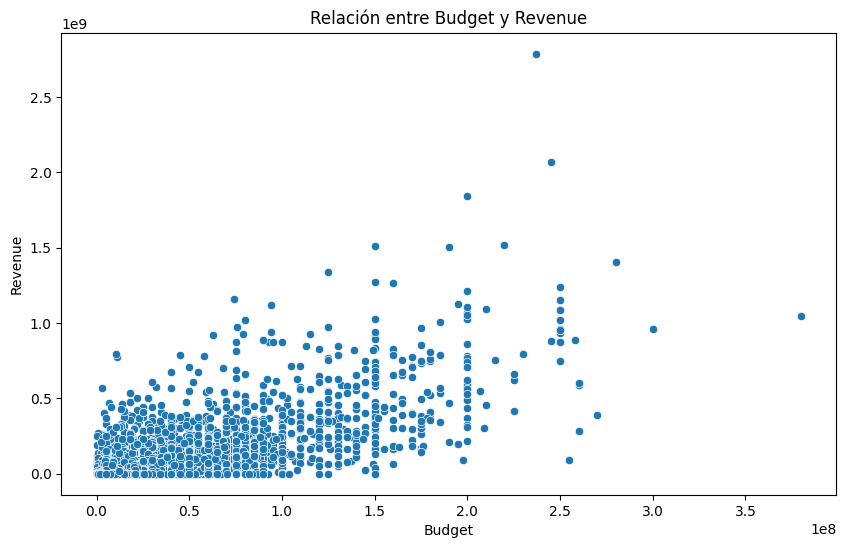

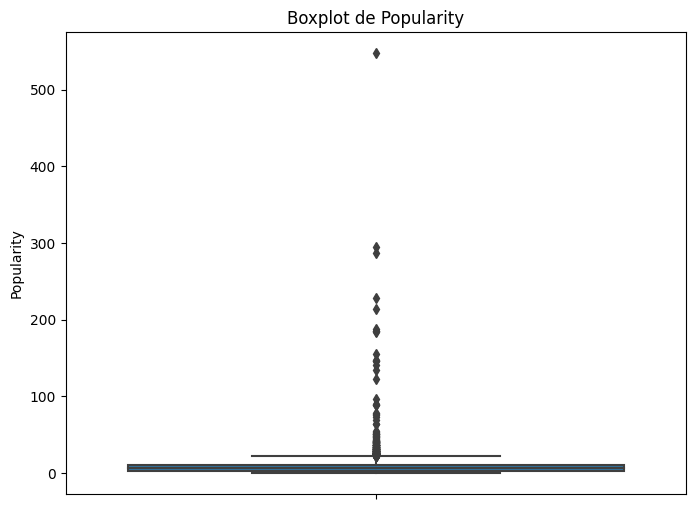

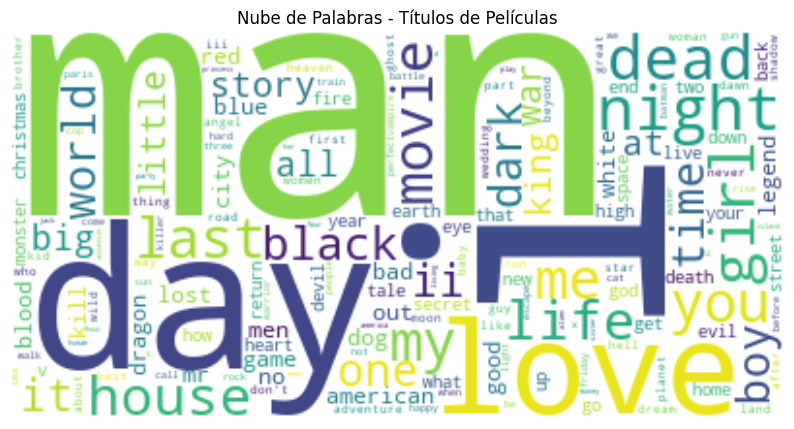

In [4]:
# Explor Data Analysis (EDA)
# Destacar un patrón importante
# Veamos la relación entre el budget y la revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleanmovies, x='budget', y='revenue')
plt.title('Relación entre Budget y Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

# Destacar los outliers
# Veamos el boxplot de la variable 'popularity'
plt.figure(figsize=(8, 6))
sns.boxplot(data=cleanmovies, y='popularity')
plt.title('Boxplot de Popularity')
plt.ylabel('Popularity')
plt.show()

# Generar una nube de palabras de la columna 'title'
title_words = ' '.join(cleanmovies['title'])
title_words = title_words.lower()
stopwords = ["to", "of", "the", "and", "&", ":", "in", "for", "on", "a", "by", "with", "an", "into", "from"]
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(title_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Títulos de Películas')
plt.show()


Nos quedamos solo con el anio de estreno `release_year` y descartamos la columna `release_date`.

In [5]:
cleanmovies.drop('release_date', axis=1, inplace=True)

Trabajamos las columna `original_language`, `language`, `overview`, `status` y `tagline`

In [6]:
language_counts = cleanmovies['language'].value_counts().sort_values(ascending=False)
print(language_counts)

language
English                                     5304
English, Español                             221
English, Français                            203
Français                                     144
Pусский                                      121
                                            ... 
普通话, English, Français, Español, 한국어/조선말       1
Deutsch, English, svenska                      1
English, Español, Français, Deutsch            1
English, Français, Srpski, ภาษาไทย             1
svenska, English, Deutsch, Pусский             1
Name: count, Length: 853, dtype: int64


In [7]:
language_counts = cleanmovies['language'].value_counts().sort_values(ascending=False)
print(language_counts)

language
English                                     5304
English, Español                             221
English, Français                            203
Français                                     144
Pусский                                      121
                                            ... 
普通话, English, Français, Español, 한국어/조선말       1
Deutsch, English, svenska                      1
English, Español, Français, Deutsch            1
English, Français, Srpski, ภาษาไทย             1
svenska, English, Deutsch, Pусский             1
Name: count, Length: 853, dtype: int64


In [8]:
cleanmovies[['original_language','language','country']][cleanmovies['original_language'].isna()]
# "english" el idioma con mayor frecuencia 

,original_language,language,country


In [9]:
# rellenamos los valores faltantes por ingles considerando la relacion con spoken languages y production_countries y ademas ingles es el predominante
cleanmovies['original_language']=cleanmovies['original_language'].fillna('en')

In [10]:
# rellenamos los registros con listas vacias en languages 
cleanmovies['language'] = cleanmovies['language'].apply(lambda x: '' if x == '[]' else x)

In [11]:
# rellenamos los valores faltantes en overview y tagline 
cleanmovies['overview'].fillna('No overview', inplace=True)
cleanmovies['tagline'].fillna('unknown', inplace=True)

In [12]:
# reemplazar los valores específicos en la columna 'overview'.
cleanmovies['overview'] = cleanmovies['overview'].replace(['no overview found', 'no overview found.'], 'no overview')

In [13]:
cleanmovies['status'].value_counts()

status
Released           8855
Post Production      12
Rumored              10
Name: count, dtype: int64

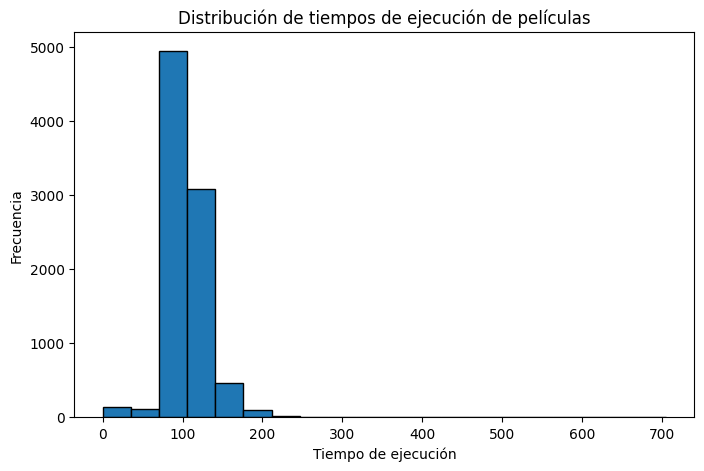

In [14]:
# Obtener los valores únicos y sus conteos en la columna 'status'

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
plt.hist(cleanmovies['runtime'], bins=20, edgecolor='black')

# Etiquetas del eje x e y
plt.xlabel('Tiempo de ejecución')
plt.ylabel('Frecuencia')
plt.title('Distribución de tiempos de ejecución de películas')

# Etiquetas del eje x e y
plt.show()

In [15]:
# revisamos si los registros nulos en status tienen inf importante
null_status_movies = cleanmovies[cleanmovies['status'].isna()]
null_status_movies[['title', 'release_year', 'runtime', 'status', 'vote_count', 'tagline', 'overview']].sort_values('release_year', ascending=False)


,title,release_year,runtime,status,vote_count,tagline,overview
21321,Iran Is Not the Problem,2008.0,79.0,NaN,2.0,Will truth be the first casualty of our next war?,A response to the failure of the American mass...
44056,Platon,2008.0,0.0,NaN,4.0,unknown,No movie overview available.
39255,Header,2006.0,89.0,NaN,4.0,unknown,HEADER portrays the grueling psychological jou...


In [16]:
# eliminamos los registros de peliculas que estan etiquetadas como rumored, canceled o vacias
cleanmovies = cleanmovies[~((cleanmovies['status'] == 'canceled') | (cleanmovies['status'] == 'rumored') | (cleanmovies['status'].isnull()))]

In [17]:
cleanmovies.shape #45035 registros

(8877, 21)

Analizamos las columnas relacionadas con la calificación de la película, como vote_average, vote_count y popularity, con el objetivo de identificar posibles valores atípicos o anomalías en los datos.

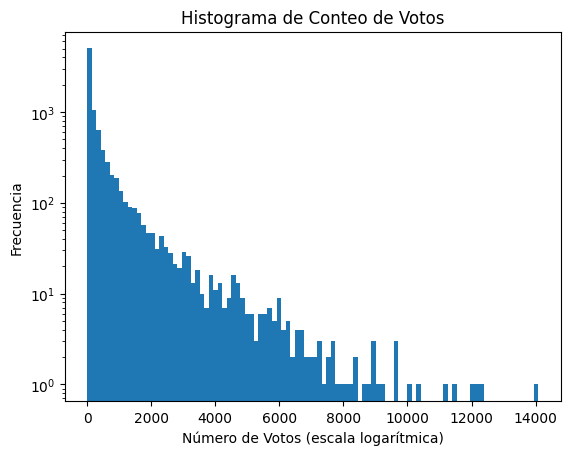

In [18]:
# Generar el histograma con escala logarítmica y 100 bins
plt.hist(cleanmovies['vote_count'], log=True, bins=100)

# Etiqueta del eje x
plt.xlabel('Número de Votos (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.title('Histograma de Conteo de Votos')

# Mostrar el histograma
plt.show()

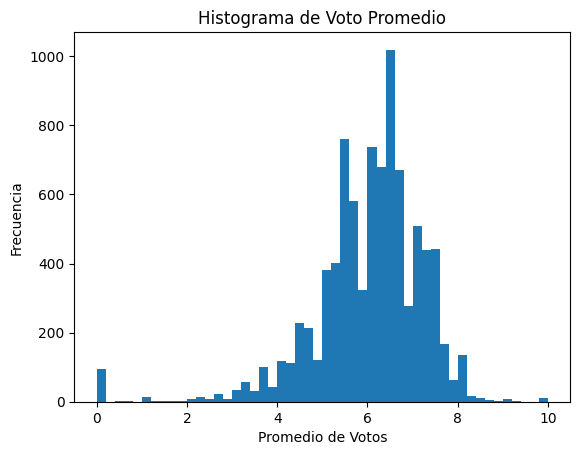

In [19]:
#realizamos histograma para ver la frecuencia de promedio de votos
# Generar el histograma con 50 bins
plt.hist(cleanmovies['vote_average'], bins=50)

# Etiquetas del eje x e y
plt.xlabel('Promedio de Votos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Voto Promedio')

# Mostrar el histograma
plt.show()

In [20]:
cleanmovies['popularity'].describe()

count    8877.000000
mean        7.373602
std        11.436464
min         0.000000
25%         2.151259
50%         6.328385
75%        10.022102
max       547.488298
Name: popularity, dtype: float64

In [21]:
# Filtrar películas con una popularidad superior a 200 y contar los valores únicos
conteo_valores = cleanmovies[cleanmovies['popularity'] > 200][['vote_average', 'vote_count', 'popularity']].value_counts()

# Imprimir el resultado
print(conteo_valores)

vote_average  vote_count  popularity
6.4           4729.0      547.488298    1
6.8           5530.0      287.253654    1
7.2           2083.0      228.032744    1
              5025.0      294.337037    1
7.8           6289.0      213.849907    1
Name: count, dtype: int64


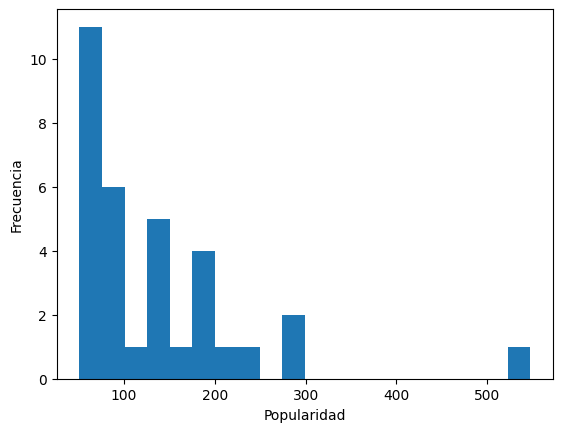

In [22]:
# Filtrar los valores de 'popularity' mayores a 50
popularity_filt = cleanmovies['popularity'][cleanmovies['popularity'] > 50]

# Generar el histograma con 20 bins
plt.hist(popularity_filt, bins=20)

# Etiquetas del eje x y y
plt.xlabel('Popularidad')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()


In [23]:
#  revisar los registros sin puntuación en las columnas 'vote_count', 
# 'vote_average' y 'popularity', y mostrar las columnas mencionadas:

registros_sin_puntuacion = cleanmovies.loc[(cleanmovies['vote_count'] == 0) & (cleanmovies['vote_average'] == 0) & (cleanmovies['popularity'] == 0), ['title', 'release_year', 'status', 'overview', 'genre']]
print(registros_sin_puntuacion)


                             title  release_year    status  \
13834         Bling: A Planet Rock           NaN  Released   
24721  America's Most Haunted Inns           NaN  Released   

                                                overview        genre  
13834  Bling is a documentary film which focuses on t...          NaN  
24721  Welcome to the modest small town of Bucks Coun...  Documentary  


In [24]:
# filtrar películas con una popularidad superior a 300 y mostrar las columnas 
# 'title', 'release_year', 'status', 'overview', 'genre' y 'vote_count':

resultado = cleanmovies[['title', 'release_year', 'status', 'overview', 'genre', 'vote_count']][cleanmovies['popularity'] > 300]
print(resultado)


         title  release_year    status  \
30677  Minions        2015.0  Released   

                                                overview  \
30677  Minions Stuart, Kevin and Bob are recruited by...   

                                      genre  vote_count  
30677  Family, Animation, Adventure, Comedy      4729.0  


Hay registros sin puntuación debido a que se trata de películas antiguas, con un año de estreno máximo en 1993. Además, es interesante notar que la película "Minions" destaca por ser la más popular en términos de votos y también por su alta popularidad durante su lanzamiento en 2015. Por lo tanto, no se considera un valor atípico en este contexto.

Examinamos el año de lanzamiento `release_year` y la duración runtime

In [25]:
conteo_duraciones = cleanmovies['runtime'].value_counts()
print(conteo_duraciones)


runtime
90.0     392
100.0    297
95.0     258
93.0     249
98.0     219
        ... 
336.0      1
272.0      1
202.0      1
352.0      1
705.0      1
Name: count, Length: 220, dtype: int64


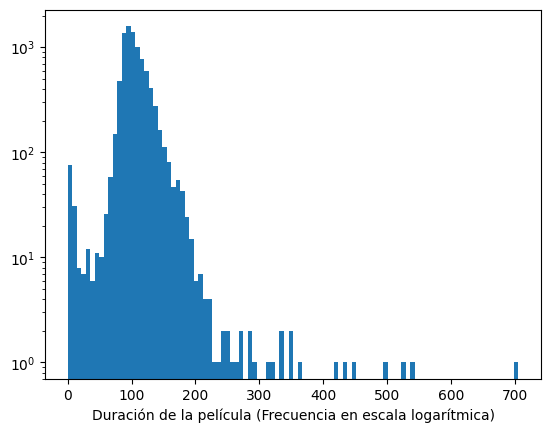

In [26]:
# Generar el histograma con escala logarítmica y 100 bins
plt.hist(cleanmovies['runtime'], log=True, bins=100)

# Etiqueta del eje x
plt.xlabel('Duración de la película (Frecuencia en escala logarítmica)')

# Mostrar el histograma
plt.show()

In [27]:
# Filtrar los registros con duración igual a cero y estado diferente a 'released'
registros_cero_duracion = cleanmovies[['title', 'release_year', 'status', 'runtime', 'genre']][(cleanmovies['runtime'] == 0) & (cleanmovies['status'] != 'released')]

# Imprimir los registros filtrados
print(registros_cero_duracion)


                                                   title  release_year  \
10668                                        After Image        2001.0   
13560                              The Land of Happiness        1993.0   
14062                                Shadow of the Eagle        2005.0   
16027                                           The Maze        2010.0   
16052                                 The Stranger in Me        2008.0   
18039                                            Hella W        2011.0   
18709                                         Like Water        2011.0   
18866  Naked Ambition: An R Rated Look at an X Rated ...        2009.0   
19898                                We Should Not Exist        2006.0   
20675                                  Kuningas Litmanen        2012.0   
21473                                          Find Love        2006.0   
22534                                       L'Antisémite        2012.0   
22717                                 

In [28]:
# Filtrar los registros con duración mayor a 600 minutos
registros_duracion_larga = cleanmovies[['title', 'release_year', 'status', 'runtime', 'genre', 'tagline', 'overview']][(cleanmovies['runtime'] > 600)]

# Imprimir los registros filtrados
print(registros_duracion_larga)


                  title  release_year    status  runtime               genre  \
43160  Band of Brothers        2001.0  Released    705.0  Action, Drama, War   

                                  tagline  \
43160  Ordinary men. Extraordinary times.   

                                                overview  
43160  Drawn from interviews with survivors of Easy C...  


Existen varios registros con duración igual a cero, de los cuales 20 están clasificados con estado como Post Production, In Production, Planned.

Las películas con duración prolongada pertenecen a géneros como drama, documentales, historia, por lo que no se consideran valores atípicos.

Con el fin de aplicar el modelo de aprendizaje automático, procederemos a descartar estos registros.

In [29]:
# Filtrar los registros con duración nula, estreno después del año 2000 y estado 'Released'
registros_nulos = cleanmovies[['title', 'release_year', 'status', 'tagline', 'overview', 'genre']][(cleanmovies['runtime'].isna()) & (cleanmovies['release_year'] > 2000) & (cleanmovies['status'] == 'Released')]

# Imprimir información sobre los registros nulos
print("De", len(registros_nulos), "registros nulos, solo", len(registros_nulos[registros_nulos['status'] == 'Released']), "fueron estrenados en este siglo y tienen estado 'Released'.")

# Sustituir los valores nulos de 'runtime' por cero
cleanmovies['runtime'] = cleanmovies['runtime'].fillna(0)

De 7 registros nulos, solo 7 fueron estrenados en este siglo y tienen estado 'Released'.


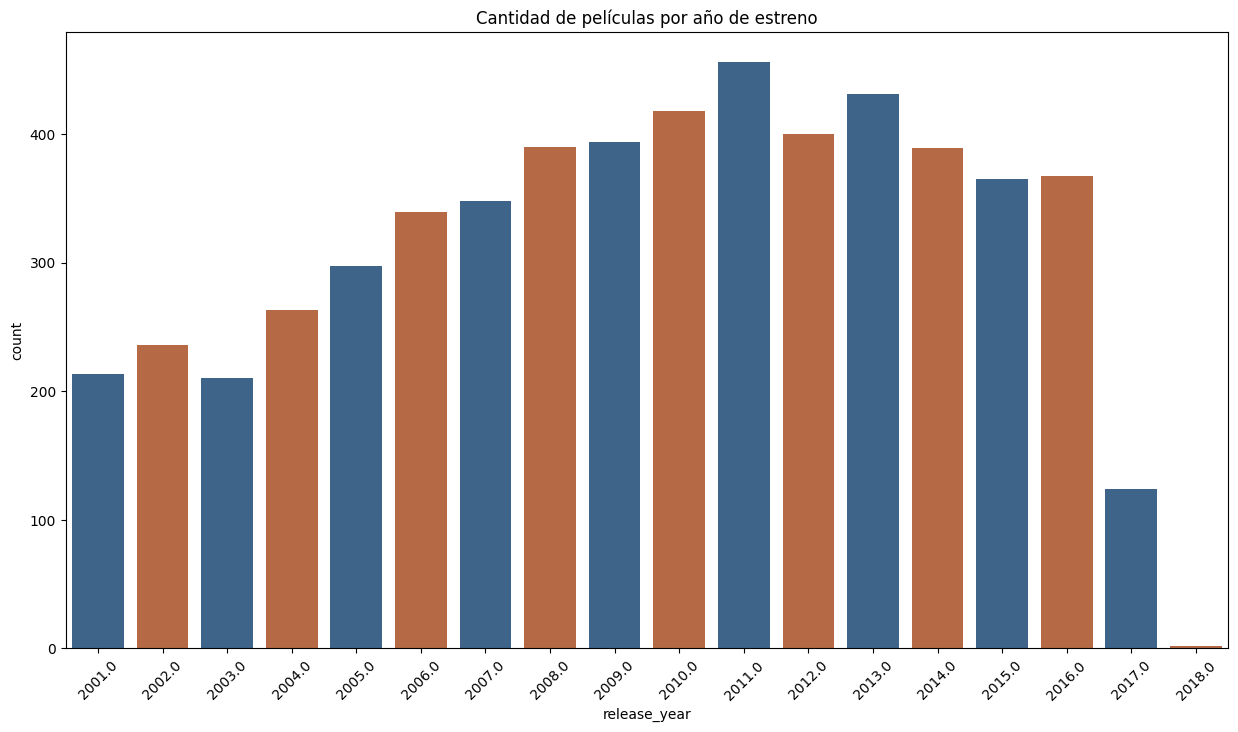

In [30]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(15, 8))

# Definir los colores corporativos utilizando valores RGB
color1 = (50/255, 100/255, 150/255)  # Ejemplo de color corporativo 1
color2 = (200/255, 100/255, 50/255)  # Ejemplo de color corporativo 2

# Crear una lista de colores personalizados
colors = [color1, color2]

# Crear el gráfico de barras utilizando seaborn y los colores personalizados
plot = sns.countplot(x=cleanmovies['release_year'][cleanmovies['release_year'] > 2000], palette=colors)

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Agregar título al gráfico
plt.title('Cantidad de películas por año de estreno')

# Mostrar el gráfico
plt.show()

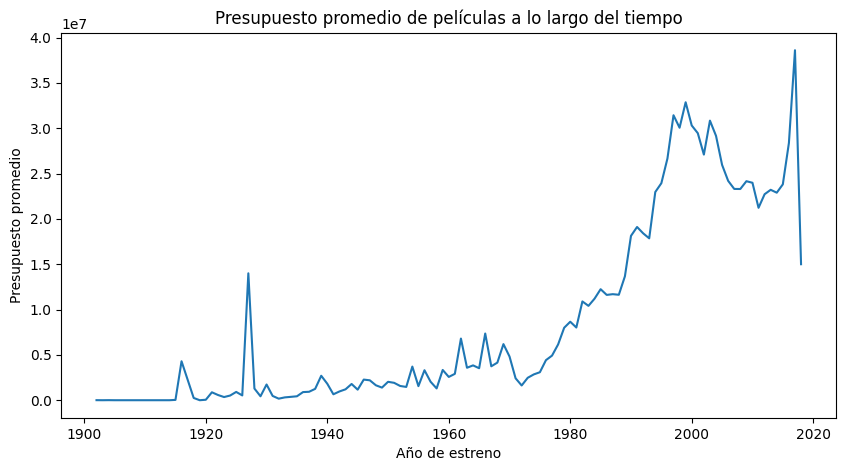

In [31]:
# Asegurar que la columna de año de estreno esté en formato numérico
cleanmovies['release_year'] = pd.to_numeric(cleanmovies['release_year'])

# Agrupar los datos por año y calcular la media del presupuesto
budget_by_year = cleanmovies.groupby('release_year')['budget'].mean()

# Crear la figura y los ejes del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Graficar el presupuesto promedio a lo largo del tiempo
ax.plot(budget_by_year)

# Configurar etiquetas de los ejes y título del gráfico
ax.set_xlabel('Año de estreno')
ax.set_ylabel('Presupuesto promedio')
ax.set_title('Presupuesto promedio de películas a lo largo del tiempo')

# Mostrar el gráfico
plt.show()


Al analizar el gráfico, se puede observar que la mayoría de las películas estrenadas se encuentran en el periodo comprendido entre 1990 y 2017. Por lo tanto, se aplicará el modelo restringido considerando únicamente las películas estrenadas a partir de 1990.


Además, se nota que el año de estreno más bajo se encuentra dentro del rango inicial del mundo cinematográfico, lo cual indica que no se considera un valor atípico o fuera de lo común.

In [32]:
cleanmovies.shape

(8877, 21)

In [33]:
cleanmovies[cleanmovies['return']>10]

,id,title,tagline,overview,collection,genre,company,original_language,runtime,popularity,...,vote_average,release_year,status,country,language,revenue,budget,return,actor,director
0,862,Toy Story,unknown,"Led by Woody, Andy's toys live happily in his ...",Toy Story Collection,"Animation, Comedy, Family",Pixar Animation Studios,en,81.0,21.946943,...,7.7,1995.0,Released,United States of America,English,3.735540e+08,30000000.0,12.451801,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter
24,451,Leaving Las Vegas,I Love You... The Way You Are.,"Ben Sanderson, an alcoholic Hollywood screenwr...",NaN,"Drama, Romance","United Artists, Intial Productions",en,112.0,10.332025,...,7.1,1995.0,Released,United States of America,English,4.980000e+07,3600000.0,13.833333,"Nicolas Cage, Elisabeth Shue, Julian Sands, Ri...",Mike Figgis
109,103,Taxi Driver,"On every street in every city, there's a nobod...",A mentally unstable Vietnam War veteran works ...,NaN,"Crime, Drama","Columbia Pictures Corporation, Italo/Judeo Pro...",en,114.0,14.092713,...,8.1,1976.0,Released,United States of America,"English, Español",2.826257e+07,1300000.0,21.740442,"Robert De Niro, Cybill Shepherd, Harvey Keitel...",Martin Scorsese
219,2292,Clerks,Just because they serve you doesn't mean they ...,Convenience and video store clerks Dante and R...,Clerks Collection,Comedy,"Miramax Films, View Askew Productions",en,92.0,10.513367,...,7.4,1994.0,Released,United States of America,English,3.151130e+06,27000.0,116.708519,"Jeff Anderson, Jason Mewes, Kevin Smith, Lisa ...",Kevin Smith
227,8467,Dumb and Dumber,"What the one doesn't have, the other is missing.",Lloyd and Harry are two men whose stupidity is...,Dumb and Dumber Collection,Comedy,"New Line Cinema, Motion Picture Corporation of...",en,107.0,9.844558,...,6.5,1994.0,Released,United States of America,English,2.472754e+08,16000000.0,15.454711,"Jim Carrey, Jeff Daniels, Lauren Holly, Teri G...","Peter Farrelly, Bobby Farrelly"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43545,350312,Baahubali 2: The Conclusion,unknown,"When Mahendra, the son of Bahubali, learns abo...",Bahubali Collection,"Action, Adventure, History, War",Arka Media Works,te,161.0,9.042261,...,6.7,2017.0,Released,India,"தமிழ், తెలుగు",2.300000e+08,18000000.0,12.777778,"Prabhas, Rana Daggubati, Sathyaraj, Anushka Sh...",S.S. Rajamouli
43598,27046,The Irony of Fate. The Sequel,unknown,Zhenya and Nadya go their separate ways. Nadya...,Ирония судьбы (Коллекция),"Comedy, Drama, Romance",Фокс,ru,125.0,1.792402,...,4.7,2007.0,Released,Russia,Pусский,5.563504e+07,5000000.0,11.127007,"Konstantin Khabenskiy, Elizaveta Boyarskaya, S...",Timur Bekmambetov
43979,324852,Despicable Me 3,Oh brother.,Gru and his wife Lucy must stop former '80s ch...,Despicable Me Collection,"Action, Animation, Adventure, Family, Comedy",Illumination Entertainment,en,96.0,36.631519,...,6.2,2017.0,Released,United States of America,English,1.020063e+09,80000000.0,12.750792,"Steve Carell, Kristen Wiig, Trey Parker, Miran...","Kyle Balda, Pierre Coffin"
44219,43228,I Was a Teenage Werewolf,Explosive! Amazing! Terrifying! You won't beli...,A meat-eating teenager (Michael Landon) sees a...,NaN,"Drama, Fantasy, Horror, Science Fiction",Sunset Productions,en,76.0,0.756840,...,5.2,1957.0,Released,United States of America,English,2.000000e+06,82000.0,24.390244,"Michael Landon, Yvonne Fedderson, Whit Bissell...",Gene Fowler Jr.


Con el objetivo de desarrollar un sistema de recomendación, hemos creado un dataset seleccionando únicamente las columnas más relevantes para aplicar técnicas de Machine Learning.

In [34]:
# Importar el dataset
cleanmovies = pd.read_csv('../dataset/cleanmovies.csv', sep=';', encoding='utf-8')

# Lista de columnas relevantes
columnas_relevantes = ['id', 'title', 'release_year', 'genre', 'overview', 'vote_average', 'vote_count', 'popularity']

# Crear un nuevo DataFrame con las columnas relevantes
data_ML = cleanmovies[columnas_relevantes].copy()

# Guardar el nuevo DataFrame en un archivo CSV
data_ML.to_csv('../dataset/recomendacion.csv', sep=',', encoding='utf8', index=False)